In [317]:
# def forward(a):
#     return np.log(a) * 10 + 300

# def inverse(a):
#     return np.exp((a - 300) / 10)
import math
def forward(a):
    return np.log(a) / np.log(1.1)

def inverse(a):
    return np.power(1.1, a)



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import datetime
import json
import pyDOE
from smt.sampling_methods import LHS
import scipy.stats as sc
from itertools import chain
from scipy.stats import kurtosis, skew, ks_2samp
from datetime import timezone
from scipy.signal import find_peaks
from scipy.stats import kurtosis, skew, ks_2samp
from statsmodels.tsa.stattools import acf
turquoise_datetime_format = "%d-%b-%Y %H:%M:%S.%f"

In [3]:

tick_size = 0.25
datestr = '20100506'
start = pd.to_datetime(datestr + ' 08:00:00')
end = pd.to_datetime(datestr + ' 12:30:00')

In [4]:
def get_synthetic_market_data(data_path, tick_size=.02):
    df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path)).set_index('time')
    df_lob_l1.index = pd.to_datetime(df_lob_l1.index, format=turquoise_datetime_format)

    l1B = df_lob_l1[df_lob_l1['side']  == 'B']
    l1S = df_lob_l1[df_lob_l1['side']  == 'S']
    
    mp = .5 * l1B['prc'] + .5 * l1S['prc']
    spread = l1S['prc'] - l1B['prc']
    spread = np.round(spread.fillna(method='ffill').fillna(method='bfill') / tick_size).dropna().astype(int)
    
    orders = pd.read_csv('{0}/orders.csv'.format(data_path)).set_index('time')
    orders.index = pd.to_datetime(orders.index, format=turquoise_datetime_format)
    
    b0 = l1B['prc'].shift(1)
    a0 = l1S['prc'].shift(1)
    depth_b = np.round((b0.reindex(orders.index) - orders['prc']) / tick_size)
    depth_a = np.round((orders['prc'] - a0.reindex(orders.index)) / tick_size)

    orders.loc[:,'depth'] = ((orders['side'] == 'B') * depth_b + (orders['side'] == 'S') * depth_a).values
    
    market_orders = orders[orders['OrdType'] == 'M'].copy()
    
    trades = pd.read_csv('{0}/trades.csv'.format(data_path)).set_index('time')
    trades.index = pd.to_datetime(trades.index, format=turquoise_datetime_format)
    
    pos = pd.read_csv('{0}/agentPosition.csv'.format(data_path)).set_index('time')
    pos.index = pd.to_datetime(pos.index, format=turquoise_datetime_format)
    
    md = {'l1B': l1B, 'l1S': l1S, 'mp': mp, 'spread': spread, 'orders': orders, 'trades': trades, 'a0': a0, 'b0': b0, 'market_orders': market_orders, 'lob_l1': df_lob_l1, 'pos': pos}
    return md

def get_fv_mv_value(data_path):
    fv = pd.read_csv('{0}/fundamental_value.csv'.format(data_path)).set_index('timestamp')
    fv.index = pd.to_datetime(fv.index, format=turquoise_datetime_format).floor('S')
    mv = pd.read_csv('{0}/momentum_value.csv'.format(data_path)).set_index('timestamp')
    mv.index = pd.to_datetime(mv.index, format=turquoise_datetime_format).floor('S')
    return fv.squeeze(), mv.squeeze()

In [9]:
run_list = sorted(os.listdir("D:/projects/simulator/Workflow/CME/Results"))
run_list = [x for x in run_list if x[0] == 'r']
print(len(run_list))
record = {str(i): 0 for i in range(1, 6)}
for sim in run_list:
    data_path = 'CME/Results/' + sim
    md = get_synthetic_market_data(data_path, tick_size=tick_size)
    raw_mp = md['mp']
    raw_mp = raw_mp.dropna().loc[start:end]
    tmp = raw_mp.resample('1S').last().fillna(method='ffill').dropna()
    tmp_min = raw_mp.resample('1min').last().fillna(method='ffill').dropna()
    close = tmp.bfill().values
    s_ret = close[1:] / close[:-1] - 1
    close_min = tmp_min.bfill().values
    s_ret_min = close_min[1:] / close_min[:-1] - 1

    # standard deviation
    reference_prc = np.mean(close)
    ret_std = np.std(s_ret)
    ret_std_min = np.std(s_ret_min)
    std_prc = reference_prc * ret_std_min
    std_dict = {str(i): i * std_prc for i in range(1, 6)}

    for i in range(1, 6):
        prominence = std_dict[str(i)]
        wlen = 600
        width = (None, 600)
        plateau_size = (None, None)
        total = 0
        peaks, infor = find_peaks(close, prominence=prominence, wlen=wlen, plateau_size=plateau_size, width=width, rel_height=1)
        total += len(peaks)
        peaks, infor = find_peaks(-1*close, prominence=prominence, wlen=wlen, plateau_size=plateau_size, width=width, rel_height=1)
        total += len(peaks)
        print(i, ": ", total)
        record[str(i)] += total

for key, value in record.items():
    record[key] = value / len(run_list)

6
1 :  299
2 :  79
3 :  26
4 :  9
5 :  2
1 :  326
2 :  58
3 :  30
4 :  4
5 :  3
1 :  277
2 :  57
3 :  7
4 :  2
5 :  1
1 :  344
2 :  81
3 :  32
4 :  15
5 :  2
1 :  288
2 :  73
3 :  17
4 :  1
5 :  1
1 :  363
2 :  92
3 :  17
4 :  2
5 :  0


In [12]:
from CMECalibration.calibration_utils import *

In [15]:
with open('CME/model_params.json', 'r', encoding='utf-8') as f:
    model_params = json.load(f)
    f.close()

In [252]:
# Mini flash crash analysis, number of occurrence.
from datetime import datetime
print(datetime.now())

limit_x_list = np.arange(300, 5501, 200).tolist()
limit_y_list = []
limit_q_list = []
for limit in limit_x_list:
    print(limit)
    model_params['MM_params']['mm_pos_limit'] = limit
    save_target_params(model_params, save_path='CME/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    
    run_list = sorted(os.listdir("D:/projects/simulator/Workflow/CME/Results"))
    run_list = [x for x in run_list if x[0] == 'r']
    # print(len(run_list))
    record = {str(i): 0 for i in range(1, 6)}
    
    detailed_record = {str(i): [] for i in range(1, 6)}
    for sim in run_list:
        data_path = 'CME/Results/' + sim
        md = get_synthetic_market_data(data_path, tick_size=tick_size)
        raw_mp = md['mp']
        raw_mp = raw_mp.dropna().loc[start:end]
        tmp = raw_mp.resample('1S').last().fillna(method='ffill').dropna()
        tmp_min = raw_mp.resample('1min').last().fillna(method='ffill').dropna()
        close = tmp.bfill().values
        s_ret = close[1:] / close[:-1] - 1
        close_min = tmp_min.bfill().values
        s_ret_min = close_min[1:] / close_min[:-1] - 1

        # standard deviation
        reference_prc = np.mean(close)
        ret_std = np.std(s_ret)
        ret_std_min = np.std(s_ret_min)
        std_prc = reference_prc * ret_std_min
        std_dict = {str(i): i * std_prc for i in range(1, 6)}

        for i in range(1, 6):
            prominence = std_dict[str(i)]
            wlen = 600
            width = (None, 600)
            plateau_size = (None, None)
            total = 0
            peaks, infor = find_peaks(close, prominence=prominence, wlen=wlen, plateau_size=plateau_size, width=width, rel_height=1)
            total += len(peaks)
            peaks, infor = find_peaks(-1*close, prominence=prominence, wlen=wlen, plateau_size=plateau_size, width=width, rel_height=1)
            total += len(peaks)
            # print(i, ": ", total)
            record[str(i)] += total
            detailed_record[str(i)].append(total)

    for key, value in record.items():
        record[key] = value / len(run_list)
    tmp_check = {str(i) : np.mean(detailed_record[str(i)]) for i in range(1, 6)}
    print(record)
    print(tmp_check)
    limit_y_list.append(record)
    tmp_quantile = [np.quantile(detailed_record[str(i)], [0.05, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.95]) for i in range(1, 6)]
    limit_q_list.append(tmp_quantile)
    print('------------------------------------------')
    
print(datetime.now())

2022-05-09 11:42:52.654068
300
{'1': 461.0208333333333, '2': 104.08333333333333, '3': 29.8125, '4': 7.604166666666667, '5': 1.4375}
{'1': 461.0208333333333, '2': 104.08333333333333, '3': 29.8125, '4': 7.604166666666667, '5': 1.4375}
------------------------------------------
500
{'1': 500.1666666666667, '2': 112.58333333333333, '3': 33.6875, '4': 7.958333333333333, '5': 1.2291666666666667}
{'1': 500.1666666666667, '2': 112.58333333333333, '3': 33.6875, '4': 7.958333333333333, '5': 1.2291666666666667}
------------------------------------------
700
{'1': 518.1041666666666, '2': 122.91666666666667, '3': 37.5625, '4': 8.729166666666666, '5': 1.375}
{'1': 518.1041666666666, '2': 122.91666666666667, '3': 37.5625, '4': 8.729166666666666, '5': 1.375}
------------------------------------------
900
{'1': 578.375, '2': 122.70833333333333, '3': 36.125, '4': 9.708333333333334, '5': 1.9583333333333333}
{'1': 578.375, '2': 122.70833333333333, '3': 36.125, '4': 9.708333333333334, '5': 1.95833333333333

In [283]:
crash_number = {}
for i in range(1, 6):
    crash_number[i] = np.array([x[i-1][3:6] for x in limit_q_list])
#     crash_number[i] = np.array([x[str(i)] for x in limit_y_list])
    print(len(crash_number[i]))

27
27
27
27
27
27


In [257]:
my_dict = {'x': limit_x_list, 'mean': limit_y_list, 'q': limit_q_list}
import pickle
with open('mini_MM_pos_limit.pkl', 'wb') as f:
    pickle.dump(my_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

In [302]:
import pickle
with open('mini_MM_pos_limit.pkl', 'rb') as f:
    MM_limit = pickle.load(f)
f.close()
with open('mini_FT_freq.pkl', 'rb') as f:
    FT_limit = pickle.load(f)
f.close()


In [320]:
mm_x_list = MM_limit['x']
mm_crash_number = {}
for i in range(1, 6):
    mm_crash_number[i] = np.array([x[i-1][3:6] for x in MM_limit['q']])
    print(len(mm_crash_number[i]))
print(len(mm_x_list))

ft_x_list = FT_limit['x']
ft_crash_number = {}
for i in range(1, 6):
    ft_crash_number[i] = np.array([x[i-1][3:6] for x in FT_limit['q']])
    print(len(ft_crash_number[i]))
print(len(ft_x_list))

mm_crash_number[2] -= 20
ft_crash_number[2] -= 20

27
27
27
27
27
27
21
21
21
21
21
21


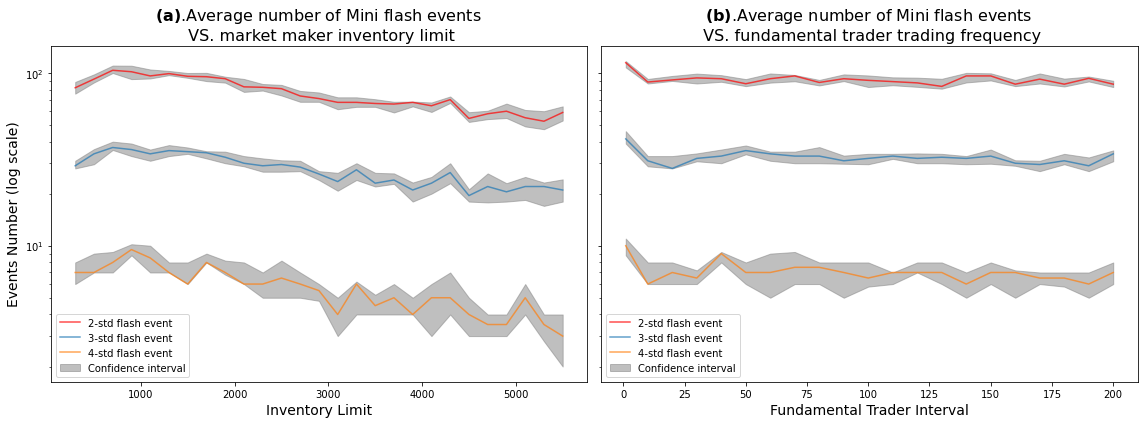

In [337]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

ax[0].plot(mm_x_list, mm_crash_number[2].T[1], label='2-std flash event', alpha=0.7, color='red')
ax[0].fill_between(mm_x_list, mm_crash_number[2].T[0], mm_crash_number[2].T[2], color='grey', alpha=0.5, label='Confidence interval')
ax[0].plot(mm_x_list, mm_crash_number[3].T[1], label='3-std flash event', alpha=0.7)
ax[0].fill_between(mm_x_list, mm_crash_number[3].T[0], mm_crash_number[3].T[2], color='grey', alpha=0.5)
ax[0].plot(mm_x_list, mm_crash_number[4].T[1], label='4-std flash event', alpha=0.7)
ax[0].fill_between(mm_x_list, mm_crash_number[4].T[0], mm_crash_number[4].T[2], color='grey', alpha=0.5)

ax[0].set_title(r'$\bf{(a)}$.Average number of Mini flash events' + ' \n VS. market maker inventory limit', size=16)
ax[0].set_xlabel('Inventory Limit', size=14)
ax[0].set_ylabel('Events Number (log scale)', size=14)
ax[0].legend(loc='best')
ax[0].set_yscale('log')
# ax[0].set_yscale('function', functions=(forward, inverse))

ax[1].plot(ft_x_list, ft_crash_number[2].T[1], label='2-std flash event', alpha=0.7, color='red')
ax[1].fill_between(ft_x_list, ft_crash_number[2].T[0], ft_crash_number[2].T[2], color='grey', alpha=0.5, label='Confidence interval')
ax[1].plot(ft_x_list, ft_crash_number[3].T[1], label='3-std flash event', alpha=0.7)
ax[1].fill_between(ft_x_list, ft_crash_number[3].T[0], ft_crash_number[3].T[2], color='grey', alpha=0.5)
ax[1].plot(ft_x_list, ft_crash_number[4].T[1], label='4-std flash event', alpha=0.7)
ax[1].fill_between(ft_x_list, ft_crash_number[4].T[0], ft_crash_number[4].T[2], color='grey', alpha=0.5)

ax[1].set_title(r'$\bf{(b)}$.Average number of Mini flash events' + ' \n VS. fundamental trader trading frequency', size=16)
ax[1].set_xlabel('Fundamental Trader Interval', size=14)
# ax[1].set_ylabel('Events Number (log scale)', size=14)
ax[1].legend(loc='best')
# ax[1].set_yscale('log')
# ax[1].set_yscale('function', functions=(forward, inverse))

fig.tight_layout()
plt.show()

In [ ]:
200
{'1': 320.625, '2': 79.64583333333333, '3': 23.8125, '4': 5.583333333333333}
{'1': 1.6025957731666878, '2': 2.59676341496716, '3': 3.4305644175430245, '4': 4.250339566763985}

In [394]:
# Mini flash crash analysis, amplitude of mini flash crash. pos_limit=4000
from datetime import datetime
print(datetime.now())

limit_x_list = np.arange(200, 501, 100).tolist()
limit_y_list = []
limit_q_list = []
limit_ampy_list = []
limit_ampq_list = []
for limit in limit_x_list:
    print(limit)
    model_params['FT_params']['ft_freq'] = limit
    save_target_params(model_params, save_path='CME/model_params.json')
    flag = run_simulation()
    assert flag == 0, "Error when running simulation!"
    
    run_list = sorted(os.listdir("D:/projects/simulator/Workflow/CME/Results"))
    run_list = [x for x in run_list if x[0] == 'r']
    # print(len(run_list))
    
    detailed_record = {str(i): [] for i in range(1, 5)}
    detailed_amp_record = {str(i): [] for i in range(1, 5)}
    for sim in run_list:
        data_path = 'CME/Results/' + sim
        md = get_synthetic_market_data(data_path, tick_size=tick_size)
        raw_mp = md['mp']
        raw_mp = raw_mp.dropna().loc[start:end]
        tmp = raw_mp.resample('1S').last().fillna(method='ffill').dropna()
        tmp_min = raw_mp.resample('1min').last().fillna(method='ffill').dropna()
        close = tmp.bfill().values
        s_ret = close[1:] / close[:-1] - 1
        close_min = tmp_min.bfill().values
        s_ret_min = close_min[1:] / close_min[:-1] - 1

        # standard deviation
        reference_prc = np.mean(close)
        ret_std = np.std(s_ret)
        ret_std_min = np.std(s_ret_min)
        std_prc = reference_prc * ret_std_min
        std_dict = {str(i): i * std_prc for i in range(1, 5)}

        for i in range(1, 5):
            prominence = std_dict[str(i)]
            wlen = 600
            width = (None, 600)
            plateau_size = (None, None)
            total = 0
            pro_res = []
            peaks, infor = find_peaks(close, prominence=prominence, wlen=wlen, plateau_size=plateau_size, width=width, rel_height=1)
            total += len(peaks)
            pro_res += infor['prominences'].tolist()
            peaks, infor = find_peaks(-1*close, prominence=prominence, wlen=wlen, plateau_size=plateau_size, width=width, rel_height=1)
            total += len(peaks)
            pro_res += infor['prominences'].tolist()
            # print(i, ": ", total)
            detailed_record[str(i)].append(total)
            if len(pro_res) > 0:
                detailed_amp_record[str(i)].append(np.mean(pro_res))

    record = {str(i) : np.mean(detailed_record[str(i)]) for i in range(1, 5)}
    print(record)
    limit_y_list.append(record)
    tmp_quantile = [np.quantile(detailed_record[str(i)], [0.05, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.95]) for i in range(1, 5)]
    limit_q_list.append(tmp_quantile)
    
    amp_record = {str(i) : np.mean(detailed_amp_record[str(i)]) for i in range(1, 5)}
    print(amp_record)
    limit_ampy_list.append(amp_record)
    amp_tmp_quantile = [np.quantile(detailed_amp_record[str(i)], [0.05, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.95]) for i in range(1, 5)]
    limit_ampq_list.append(amp_tmp_quantile)
    print('------------------------------------------')
    
print(datetime.now())

2022-05-12 10:01:40.790094
200
{'1': 320.625, '2': 79.64583333333333, '3': 23.8125, '4': 5.583333333333333}
{'1': 1.6025957731666878, '2': 2.59676341496716, '3': 3.4305644175430245, '4': 4.250339566763985}
------------------------------------------
300
{'1': 336.7083333333333, '2': 84.8125, '3': 25.208333333333332, '4': 4.833333333333333}
{'1': 1.5660558688385138, '2': 2.530013381326516, '3': 3.3061790291267155, '4': 4.0864383678337175}
------------------------------------------
400
{'1': 331.7083333333333, '2': 85.5, '3': 24.4375, '4': 5.5}
{'1': 1.5817171520430577, '2': 2.5500397599162503, '3': 3.358787897265788, '4': 4.07529026679842}
------------------------------------------
500
{'1': 339.0625, '2': 85.89583333333333, '3': 26.0625, '4': 6.895833333333333}
{'1': 1.5494600563885677, '2': 2.5094948294108836, '3': 3.3071907532865708, '4': 4.066891897165335}
------------------------------------------
2022-05-12 10:34:19.333189


In [374]:
my_dict = {'x': limit_x_list, 'mean': limit_ampy_list, 'q': limit_ampq_list}
import pickle
with open('miniamp_FT_freq.pkl', 'wb') as f:
    pickle.dump(my_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

my_dict = {'x': limit_x_list, 'mean': limit_y_list, 'q': limit_q_list}
import pickle
with open('mini_FT_freq_compare.pkl', 'wb') as f:
    pickle.dump(my_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
f.close()

In [375]:
crash_amp = {}
for i in range(1, 5):
    crash_amp[i] = np.array([x[i-1][3:6] for x in limit_ampq_list])
#     crash_amp[i] = np.array([x[str(i)] for x in limit_ampy_list])
    print(len(crash_amp[i]))

21
21
21
21


In [392]:
import pickle
with open('miniamp_MM_pos_limit.pkl', 'rb') as f:
    MMamp_limit = pickle.load(f)
f.close()
with open('miniamp_FT_freq.pkl', 'rb') as f:
    FTamp_limit = pickle.load(f)
f.close()



mm_x_list = MMamp_limit['x']
mm_crash_amp = {}
for i in range(1, 5):
    mm_crash_amp[i] = np.array([x[i-1][3:6] for x in MMamp_limit['q']])
    print(len(mm_crash_amp[i]))
print(len(mm_x_list))

ft_x_list = FTamp_limit['x'][2:]
ft_crash_amp = {}
for i in range(1, 5):
    ft_crash_amp[i] = np.array([x[i-1][3:6] for x in FTamp_limit['q'][2:]])
    print(len(ft_crash_amp[i]))
print(len(ft_x_list))

27
27
27
27
27
19
19
19
19
19


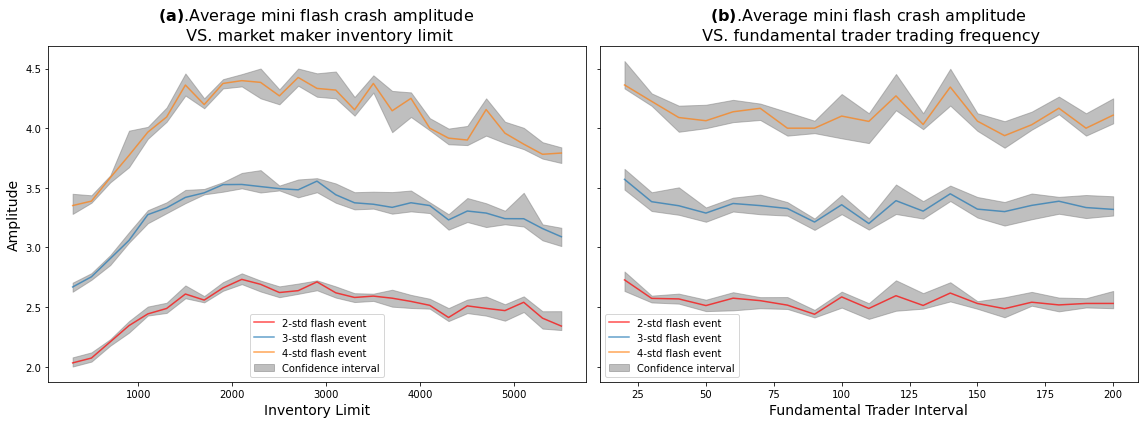

In [393]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

ax[0].plot(mm_x_list, mm_crash_amp[2].T[1], label='2-std flash event', alpha=0.7, color='red')
ax[0].fill_between(mm_x_list, mm_crash_amp[2].T[0], mm_crash_amp[2].T[2], color='grey', alpha=0.5, label='Confidence interval')
ax[0].plot(mm_x_list, mm_crash_amp[3].T[1], label='3-std flash event', alpha=0.7)
ax[0].fill_between(mm_x_list, mm_crash_amp[3].T[0], mm_crash_amp[3].T[2], color='grey', alpha=0.5)
ax[0].plot(mm_x_list, mm_crash_amp[4].T[1], label='4-std flash event', alpha=0.7)
ax[0].fill_between(mm_x_list, mm_crash_amp[4].T[0], mm_crash_amp[4].T[2], color='grey', alpha=0.5)

ax[0].set_title(r'$\bf{(a)}$.Average mini flash crash amplitude' + ' \n VS. market maker inventory limit', size=16)
ax[0].set_xlabel('Inventory Limit', size=14)
ax[0].set_ylabel('Amplitude', size=14)
ax[0].legend(loc='best')
# ax[0].set_yscale('log')
# ax[0].set_yscale('function', functions=(forward, inverse))


ax[1].plot(ft_x_list, ft_crash_amp[2].T[1], label='2-std flash event', alpha=0.7, color='red')
ax[1].fill_between(ft_x_list, ft_crash_amp[2].T[0], ft_crash_amp[2].T[2], color='grey', alpha=0.5, label='Confidence interval')
ax[1].plot(ft_x_list, ft_crash_amp[3].T[1], label='3-std flash event', alpha=0.7)
ax[1].fill_between(ft_x_list, ft_crash_amp[3].T[0], ft_crash_amp[3].T[2], color='grey', alpha=0.5)
ax[1].plot(ft_x_list, ft_crash_amp[4].T[1], label='4-std flash event', alpha=0.7)
ax[1].fill_between(ft_x_list, ft_crash_amp[4].T[0], ft_crash_amp[4].T[2], color='grey', alpha=0.5)

ax[1].set_title(r'$\bf{(b)}$.Average mini flash crash amplitude' + ' \n VS. fundamental trader trading frequency', size=16)
ax[1].set_xlabel('Fundamental Trader Interval', size=14)
# ax[1].set_ylabel('Events Number (log scale)', size=14)
ax[1].legend(loc='best')
# ax[1].set_yscale('log')
# ax[1].set_yscale('function', functions=(forward, inverse))

fig.tight_layout()
plt.show()